In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D, Flatten, Dropout,BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from google.colab import files
import os
import cv2
from PIL import Image 
from keras.utils import normalize

In [ ]:
image_data = '/content/drive/My Drive/Mito/images/'
masks_data = '/content/drive/My Drive/Mito/masks/'

In [ ]:
size = 256
image_dataset = []
mask_dataset = []

imagenes = sorted(os.listdir(image_data))
for i, image_name in enumerate(imagenes):
  if (image_name.split('.')[1] == 'tif'):
    image = cv2.imread(image_data+image_name, 0)
    image_dataset.append(np.array(image))

In [ ]:
masks = sorted(os.listdir(masks_data))
for i, image_name in enumerate(masks):
  if (image_name.split('.')[1] == 'tif'):
    image = cv2.imread(masks_data+image_name, 0)
    mask_dataset.append(np.array(image))

In [ ]:
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)

In [ ]:
mask_dataset = np.expand_dims((np.array(mask_dataset)), 3)/255.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state = 0)

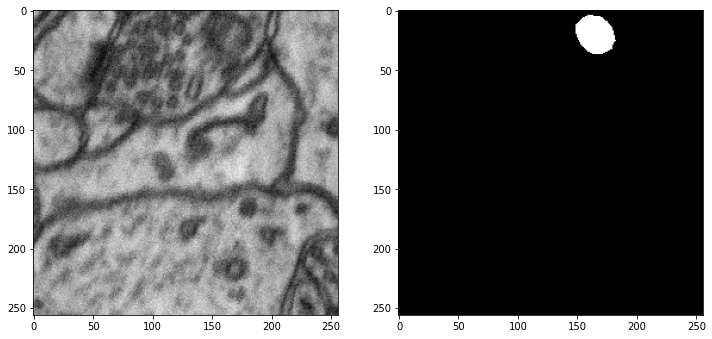

In [ ]:
import random
from google.colab.patches import cv2_imshow


image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number],(256,256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number],(256,256)), cmap='gray')
plt.show()

In [ ]:
inputs = tf.keras.layers.Input((256, 256, 1))
s = inputs
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
checkpoint_path = '/content/drive/My Drive/Modeloscheck/model.{epoch:02d}-{val_loss:.2f}.hdf5'
keras_callbacks   = [ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),TensorBoard(log_dir="logs",)]

In [ ]:
model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=[keras_callbacks])

Epoch 1/25
101/101 [==============================] - 52s 165ms/step - loss: 0.2778 - accuracy: 0.9414 - val_loss: 0.2628 - val_accuracy: 0.9442
Epoch 2/25
101/101 [==============================] - 14s 139ms/step - loss: 0.1542 - accuracy: 0.9436 - val_loss: 0.2007 - val_accuracy: 0.9472
Epoch 3/25
101/101 [==============================] - 14s 142ms/step - loss: 0.0778 - accuracy: 0.9687 - val_loss: 0.1073 - val_accuracy: 0.9675
Epoch 4/25
101/101 [==============================] - 15s 145ms/step - loss: 0.0471 - accuracy: 0.9818 - val_loss: 0.0456 - val_accuracy: 0.9829
Epoch 5/25
101/101 [==============================] - 15s 147ms/step - loss: 0.0309 - accuracy: 0.9881 - val_loss: 0.0422 - val_accuracy: 0.9845
Epoch 6/25
101/101 [==============================] - 15s 148ms/step - loss: 0.0242 - accuracy: 0.9906 - val_loss: 0.0341 - val_accuracy: 0.9879
Epoch 7/25
101/101 [==============================] - 15s 146ms/step - loss: 0.0195 - accuracy: 0.9925 - val_loss: 0.0180 - val_ac

In [ ]:
Imagen_prueba = cv2.imread('/content/drive/My Drive/Mito/images/subpage125_11.tif',0)
Image_prueba_norm = np.expand_dims(normalize(np.array(Imagen_prueba), axis=1),2)
Imagen_prueba_norm = Image_prueba_norm[:,:,0][:,:,None]
Imagen_prueba_input = np.expand_dims(Imagen_prueba_norm,0)

Prediction = (model.predict(Imagen_prueba_input)[0,:,:,0]>0.7).astype(np.uint8)

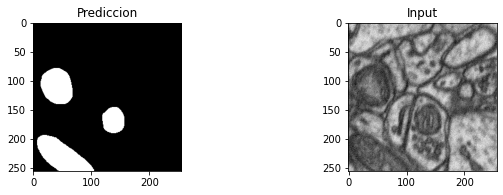

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(231)
plt.title("Prediccion")
plt.imshow(Prediction, cmap='gray')
plt.subplot(232)
plt.title("Input")
plt.imshow(Imagen_prueba, cmap='gray')
plt.show()

In [ ]:
plt.imsave('/content/drive/My Drive/Imagen2.jpg',Prediction, cmap='gray')

In [ ]:
img = cv2.imread('/content/drive/My Drive/Imagen2.jpg')
img_gray = img[:,:,0]

In [ ]:
ret1, the = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [ ]:
kernel = np.ones((3,3), np.uint8)
open = cv2.morphologyEx(the,cv2.MORPH_OPEN,kernel,iterations=2)

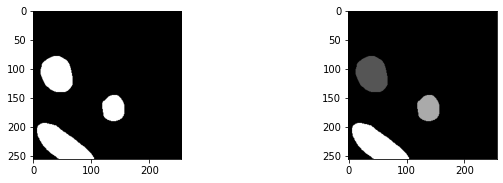

In [ ]:
kernel = np.ones((3,3), np.uint8)
open = cv2.morphologyEx(the,cv2.MORPH_OPEN,kernel,iterations=2)
#SPLIT - CONNECTED COMPONENTES
ret3, markers = cv2.connectedComponents(open)

plt.figure(figsize=(16,6))
plt.subplot(231)
plt.imshow(open, cmap='gray')
plt.subplot(232)
plt.imshow(markers, cmap='gray')
plt.show()

In [ ]:
markers = markers+10
markers = cv2.watershed(img, markers)

In [ ]:
from skimage import measure, color, io
props = measure.regionprops_table(markers, intensity_image=img_gray, properties=['label','area','equivalent_diameter','mean_intensity','solidity'])

In [ ]:
import pandas as pd
df = pd.DataFrame(props)
print(df)

   label   area  equivalent_diameter  mean_intensity  solidity
0     10  57029           269.465356        0.163671  0.883951
1     11   2698            58.610582      254.162713  0.987194
2     12   1395            42.144622      253.690323  0.983087
3     13   3394            65.737166      253.996464  0.981492
